In [ ]:
# download model.pt

!pip install gdown
!gdown --id 1If5gkWEfChJHc8v8CCEhGhEeeAqsxKTz

In [2]:
import math
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchdiffeq import odeint_adjoint as odeint
from tqdm import tqdm 
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.models import UNet


device = 'cuda'

# define small pretrained unet

net = UNet(
    input_channels=1,
    input_height=28,
    ch=32,
    ch_mult=(1, 2),
    num_res_blocks=2,
    attn_resolutions=(16,),
    resamp_with_conv=True,
).to(device)

net.load_state_dict(torch.load('model_final_mnist_dirichlet.pt'))
net.eval()

# load testset and define latent distribution
transform = transforms.Compose([transforms.ToTensor()])
diri = torch.distributions.Dirichlet(torch.ones(784))
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def upsample(x, sf=2):
    '''s-fold upsampler

    Upsampling the spatial size by filling the new entries with zeros

    x: tensor image, NxCxWxH
    '''
    st = 0
    z = torch.zeros(
        (x.shape[0],
         x.shape[1],
         x.shape[2] *
         sf,
         x.shape[3] *
         sf)).type_as(x)
    z[..., st::sf, st::sf].copy_(x)
    return z

def downsample(x, sf=2):
    '''s-fold downsampler

    Keeping the upper-left pixel for each distinct sfxsf patch and discarding the others

    x: tensor image, NxCxWxH
    '''
    st = 0
    return x[..., st::sf, st::sf]


class cnf(torch.nn.Module):

    def __init__(self, model):
        super().__init__()
        self.model = model

    def model_forward(self, x, t):
        return self.model(x, t)

    def forward(self, t, x):
        with torch.no_grad():
            z = self.model_forward(x, t.repeat(x.shape[0]))
        return z

cont_nf = cnf(net)

# routines for d flow
def forward_flow_matching(net, z):
    steps = 6
    delta = 1 / (steps - 1)
    for i in range(steps - 1):
        t1 = torch.ones(len(z), device=device) * delta * i
        z = z + delta * net(z + (delta / 2)* net(z, t1), t1 + delta / 2)
    return z


def inverse_flow_matching(cnf, z):
    z_t = odeint(cnf, z,
                 torch.tensor([1.0, 0.0]).to(device),
                 atol=1e-5,
                 rtol=1e-5,
                 method='dopri5',
                 )
    x = z_t[-1].detach()
    return x

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:24<00:00,  4.20s/it]


tensor([0.9757, 0.9802, 0.9707, 0.9760, 0.9714, 0.9790, 0.9785, 0.9772, 0.9745,
        0.9778, 0.9693, 0.9778, 0.9763, 0.9771, 0.9701, 0.9784],
       device='cuda:0', grad_fn=<SumBackward1>)


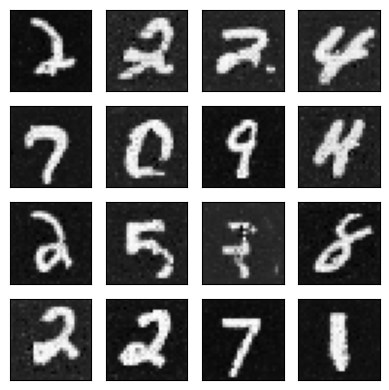

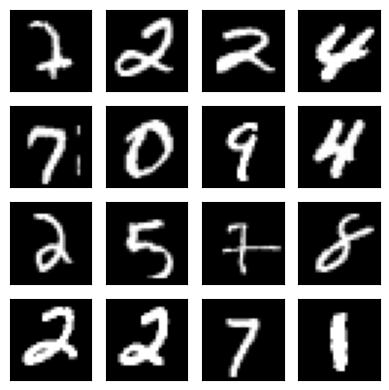

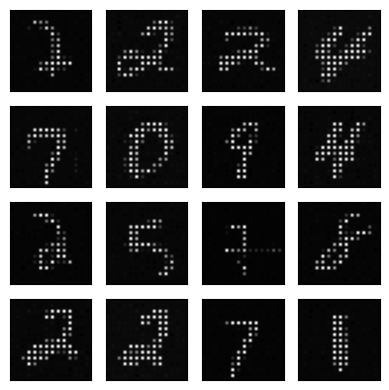

tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0064, device='cuda:0')


In [3]:
## Superresolution Experiment

# load batch and normalize it to the simplex
torch.manual_seed(0)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                          shuffle=True, num_workers=1)

batch,y  = next(iter(testloader))
batch = batch.to(device)
batch = batch/torch.sum(batch, dim = (1,2,3)).unsqueeze(1).unsqueeze(1).unsqueeze(1)


batch_y = batch.clone().to(device)
batch_y = downsample(batch_y) + torch.randn_like(downsample(batch_y))*0.0001

steps = 20
x = batch_y.clone().to(device)
x = upsample(x)

z = inverse_flow_matching(cont_nf, x).to(device)
z = np.sqrt(0.1) * z + np.sqrt(1 -0.1) * diri.sample([16]).view(16,1,28,28).to(device)
z = z.detach().requires_grad_(True)

# start the gradient descent
optim_img = torch.optim.LBFGS(
    [z], max_iter=20, history_size=100, line_search_fn='strong_wolfe')
d = z.shape[1] * z.shape[2] * z.shape[3]

tq = tqdm(range(steps))
for iteration in tq:

    def closure():
        optim_img.zero_grad()  # Reset gradients
        reg = (torch.sum(z, dim = (1,2,3)) - torch.ones(z.shape[0], device = device))**2
        loss = (torch.sum((downsample(forward_flow_matching(net, z))-
                batch_y)**2, dim=(1, 2, 3))).mean() + 1000*reg.mean()
        loss.backward()  # Compute gradients
        return loss

    optim_img.step(closure)

z = z.detach().requires_grad_(False)
restored_img = forward_flow_matching(net, z.detach())

print(torch.sum(restored_img, dim = (1,2,3)))

f, axarr = plt.subplots(4,4, figsize = (4,4))
for k in range(4):
    for l in range(4):
        axarr[k,l].imshow(restored_img.cpu().data.numpy()[k*4+l].reshape(28,28), cmap = 'gray')
        axarr[k,l].get_yaxis().set_ticks([])
        axarr[k,l].get_xaxis().set_ticks([])
plt.tight_layout()
#plt.savefig("Dreco.png")
plt.show()

f, axarr = plt.subplots(4,4, figsize = (4,4))
for k in range(4):
    for l in range(4):
        axarr[k,l].imshow(batch.cpu().data.numpy()[k*4+l].reshape(28,28), cmap = 'gray')
        axarr[k,l].get_yaxis().set_ticks([])
        axarr[k,l].get_xaxis().set_ticks([])
plt.tight_layout()
plt.show()


f, axarr = plt.subplots(4,4, figsize = (4,4))
for k in range(4):
    for l in range(4):
        axarr[k,l].imshow(x.cpu().data.numpy()[k*4+l].reshape(28,28), cmap = 'gray')
        axarr[k,l].get_yaxis().set_ticks([])
        axarr[k,l].get_xaxis().set_ticks([])
plt.tight_layout()
plt.show()

print(torch.sum((batch-restored_img)**2)/len(batch))
print(torch.sum((batch-upsample(batch_y))**2)/len(batch))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:09<00:00,  3.50s/it]


tensor([0.9681, 0.9830, 0.9807, 0.9770, 0.9809, 0.9786, 0.9757, 0.9752, 0.9775,
        0.9662, 0.9732, 0.9671, 0.9806, 0.9775, 0.9683, 0.9739],
       device='cuda:0', grad_fn=<SumBackward1>)


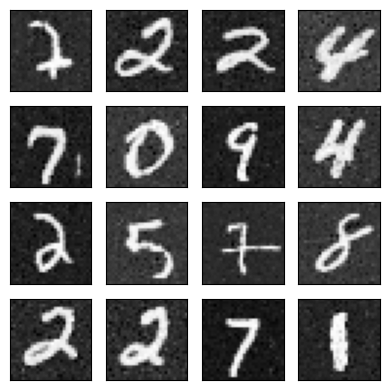

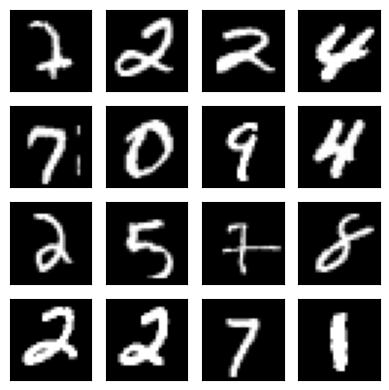

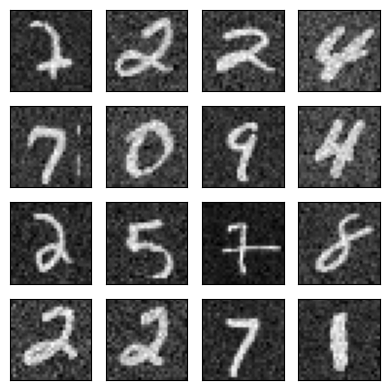

tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0008, device='cuda:0')


In [19]:
# Denoising Experiment

batch_y = batch.clone().to(device)
torch.manual_seed(1)
batch_y = batch_y + torch.randn_like(batch_y)*0.001

steps = 20
x = batch_y.clone().to(device)

z = inverse_flow_matching(cont_nf, x).to(device)
z = np.sqrt(0.1) * z + np.sqrt(1 - 0.1) * diri.sample([16]).view(16,1,28,28).to(device)
z = z.detach().requires_grad_(True)

# start the gradient descent
optim_img = torch.optim.LBFGS(
    [z], max_iter=20, history_size=100, line_search_fn='strong_wolfe')
d = z.shape[1] * z.shape[2] * z.shape[3]

tq = tqdm(range(steps))
for iteration in tq:

    def closure():
        optim_img.zero_grad()  # Reset gradients
        reg = (torch.sum(z, dim = (1,2,3)) - torch.ones(z.shape[0], device = device))**2
        loss = (torch.sum((forward_flow_matching(net, z) -
                batch_y)**2, dim=(1, 2, 3))).mean() + 10000*reg.mean()
        loss.backward()  # Compute gradients
        return loss

    optim_img.step(closure)

z = z.detach().requires_grad_(False)
restored_img = forward_flow_matching(net, z.detach())

print(torch.sum(restored_img, dim = (1,2,3)))

f, axarr = plt.subplots(4,4, figsize = (4,4))
for k in range(4):
    for l in range(4):
        axarr[k,l].imshow(restored_img.cpu().data.numpy()[k*4+l].reshape(28,28), cmap = 'gray')
        axarr[k,l].get_yaxis().set_ticks([])
        axarr[k,l].get_xaxis().set_ticks([])
plt.tight_layout()
#plt.savefig("Dreco_den.png",bbox_inches = 'tight')
plt.show()

f, axarr = plt.subplots(4,4, figsize = (4,4))
for k in range(4):
    for l in range(4):
        axarr[k,l].imshow(batch.cpu().data.numpy()[k*4+l].reshape(28,28), cmap = 'gray')
        axarr[k,l].get_yaxis().set_ticks([])
        axarr[k,l].get_xaxis().set_ticks([])
plt.tight_layout()
plt.show()


f, axarr = plt.subplots(4,4, figsize = (4,4))
for k in range(4):
    for l in range(4):
        axarr[k,l].imshow(batch_y.cpu().data.numpy()[k*4+l].reshape(28,28), cmap = 'gray')
        axarr[k,l].get_yaxis().set_ticks([])
        axarr[k,l].get_xaxis().set_ticks([])
plt.tight_layout()
plt.show()

print(torch.sum((batch-restored_img)**2)/len(batch))
print(torch.sum((batch-batch_y)**2)/len(batch))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:10<00:00,  3.51s/it]


tensor([0.9909, 0.9928, 0.9905, 0.9953, 0.9793, 0.9969, 0.9908, 0.9988, 0.9869,
        0.9873, 0.9898, 0.9907, 0.9952, 0.9979, 0.9866, 0.9899],
       device='cuda:0', grad_fn=<SumBackward1>)


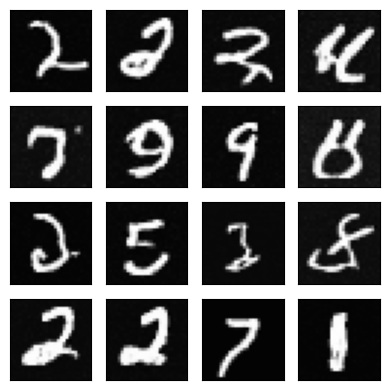

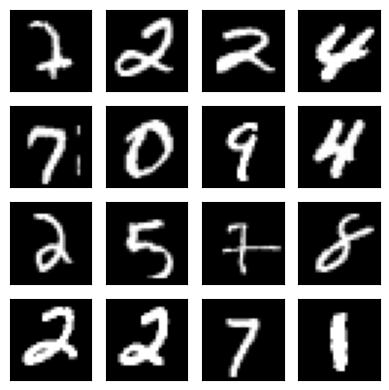

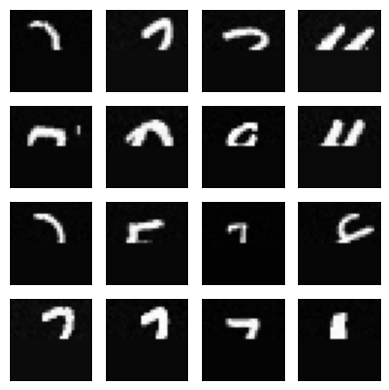

tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0049, device='cuda:0')


In [20]:
## Inpainting Experiment

batch_y = batch.clone().to(device)
torch.manual_seed(2)
batch_y = batch_y[:,:,:14,:] + torch.randn_like(batch_y[:,:,:14,:])*0.0001

steps = 20
x = batch_y.clone().to(device)
x = torch.cat((x, torch.zeros_like(x)),2)

z = inverse_flow_matching(cont_nf, x).to(device)
z = np.sqrt(0.1) * z + np.sqrt(1 - 0.1) * diri.sample([16]).view(16,1,28,28).to(device)
z = z.detach().requires_grad_(True)

# start the gradient descent
optim_img = torch.optim.LBFGS(
    [z], max_iter=20, history_size=100, line_search_fn='strong_wolfe')
d = z.shape[1] * z.shape[2] * z.shape[3]

tq = tqdm(range(steps))
for iteration in tq:

    def closure():
        optim_img.zero_grad()  # Reset gradients
        reg = (torch.sum(z, dim = (1,2,3)) - torch.ones(z.shape[0], device = device))**2
        loss = (torch.sum((forward_flow_matching(net, z)[:,:,:14,:] -
                batch_y)**2, dim=(1, 2, 3))).mean() + 100*reg.mean()
        loss.backward()  # Compute gradients
        return loss

    optim_img.step(closure)

z = z.detach().requires_grad_(False)
restored_img = forward_flow_matching(net, z.detach())

print(torch.sum(restored_img, dim = (1,2,3)))

f, axarr = plt.subplots(4,4, figsize = (4,4))
for k in range(4):
    for l in range(4):
        axarr[k,l].imshow(restored_img.cpu().data.numpy()[k*4+l].reshape(28,28), cmap = 'gray')
        axarr[k,l].get_yaxis().set_ticks([])
        axarr[k,l].get_xaxis().set_ticks([])
plt.tight_layout()
#plt.savefig("Dreco_inp.png")
plt.show()

f, axarr = plt.subplots(4,4, figsize = (4,4))
for k in range(4):
    for l in range(4):
        axarr[k,l].imshow(batch.cpu().data.numpy()[k*4+l].reshape(28,28), cmap = 'gray')
        axarr[k,l].get_yaxis().set_ticks([])
        axarr[k,l].get_xaxis().set_ticks([])
plt.tight_layout()
plt.show()


f, axarr = plt.subplots(4,4, figsize = (4,4))
for k in range(4):
    for l in range(4):
        axarr[k,l].imshow(x.cpu().data.numpy()[k*4+l].reshape(28,28), cmap = 'gray')
        axarr[k,l].get_yaxis().set_ticks([])
        axarr[k,l].get_xaxis().set_ticks([])
plt.tight_layout()
plt.show()

print(torch.sum((batch-restored_img)**2)/len(batch))
print(torch.sum((batch-torch.cat((batch_y, torch.zeros_like(batch_y)),2))**2)/len(batch))